In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from simulate import SimulationDataset  
import jax
from jax import jit, vmap, grad, random, value_and_grad
import jax.numpy as jnp


### Set device

In [3]:
seed = 0
# random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("Using CPU")



Using MPS (Apple Silicon)


### Define the parameters for the simulation

In [4]:
ns = 10000
sim = 'spring'
n = 4
dim = 2
nt = 1000
dt = 1e-2

### Generate the dataset and see the shape

In [5]:
import simulate
from simulate import SimulationDataset
simulation = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
simulation.simulate(ns)

In [6]:
simulation.data.shape

(10000, 500, 4, 6)

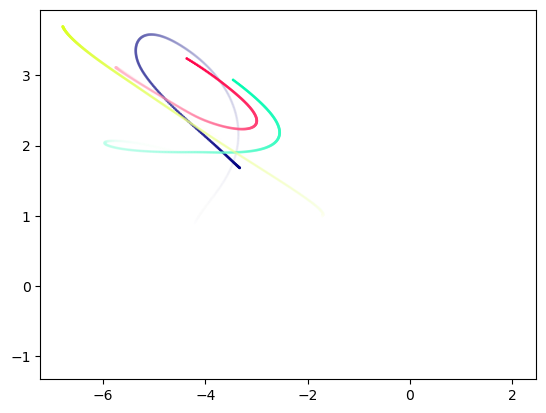

In [7]:
simulation.plot(0, animate=True, plot_size=False)

### Split the data and put into dataloader

In [8]:
accel_data = simulation.get_acceleration()

# Convert simulation and acceleration data directly to tensors
X = torch.tensor(np.array(simulation.data), dtype=torch.float32)  # Shape: (num_samples, num_time_steps, num_particles, num_features)
Y = torch.tensor(np.array(accel_data), dtype=torch.float32)       # Shape: (num_samples, num_time_steps, num_particles, output_dim)

# Select every 5th timestep along time dimension
X = X[:, ::5].reshape(-1, X.shape[2], X.shape[3])  # Flatten sample & time dims
Y = Y[:, ::5].reshape(-1, Y.shape[2], Y.shape[3])  # Flatten sample & time dims

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False)

In [9]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

torch.Size([750000, 4, 6]) torch.Size([250000, 4, 6]) torch.Size([750000, 4, 2]) torch.Size([250000, 4, 2])


In [10]:
from models import NbodyGNN,get_edge_index

edge_index = get_edge_index(n, sim)


from torch_geometric.data import Data, DataLoader

train_data_list = [
    Data(
        x=X_train[i],  
        edge_index=edge_index,  
        y=Y_train[i]
    ) for i in range(len(Y_train))
]


test_indices = np.random.choice(len(X_test), size=1024, replace=False)  # Randomly select 1024 indices from the test set
test_data_list = [
    Data(
        x=X_test[i],  
        edge_index=edge_index,  
        y=Y_test[i]
    ) for i in test_indices
]


batch = 64

trainloader = DataLoader(train_data_list, batch_size=batch, shuffle=True)
testloader = DataLoader(test_data_list, batch_size=1024, shuffle=False)


/Users/liuyihao/Desktop/yl2063/src/models.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e3pikzc5fh/croot/libtorch_1738337599132/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Standard model

In [11]:
aggr = 'add'
hidden = 300
msg_dim = 100
n_f = simulation.data.shape[3]

In [12]:
from torch.optim.lr_scheduler import OneCycleLR
initial_learing_rate = 1e-3


total_epochs = 30


batch_per_epoch = len(trainloader)


batch_per_epoch

11719

In [13]:

model_standard = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_standard = torch.optim.Adam(model_standard.parameters(), lr=initial_learing_rate, weight_decay=1e-8)


sched_standard = OneCycleLR(opt_standard, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [14]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-spring-standard", reinit=True)

for epoch in range(total_epochs):
    model_standard.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_standard.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_standard.loss(batch)
        loss.backward()
        opt_standard.step()
        sched_standard.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 8.274901
Epoch 2/30, Loss: 3.736582
Epoch 3/30, Loss: 2.941197
Epoch 4/30, Loss: 2.322236
Epoch 5/30, Loss: 1.793950
Epoch 6/30, Loss: 1.493980
Epoch 7/30, Loss: 1.326481
Epoch 8/30, Loss: 1.219893
Epoch 9/30, Loss: 1.120596
Epoch 10/30, Loss: 1.007530
Epoch 11/30, Loss: 0.925894
Epoch 12/30, Loss: 0.843337
Epoch 13/30, Loss: 0.776257
Epoch 14/30, Loss: 0.708521
Epoch 15/30, Loss: 0.654954
Epoch 16/30, Loss: 0.598819
Epoch 17/30, Loss: 0.552727
Epoch 18/30, Loss: 0.504260
Epoch 19/30, Loss: 0.463218
Epoch 20/30, Loss: 0.419281
Epoch 21/30, Loss: 0.377890
Epoch 22/30, Loss: 0.342938
Epoch 23/30, Loss: 0.310362
Epoch 24/30, Loss: 0.280854
Epoch 25/30, Loss: 0.253826
Epoch 26/30, Loss: 0.232380
Epoch 27/30, Loss: 0.214877
Epoch 28/30, Loss: 0.201825
Epoch 29/30, Loss: 0.193150
Epoch 30/30, Loss: 0.188897


In [15]:
# Save the model state
import os

root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "spring_standard.pth")

torch.save(model_standard.state_dict(), save_path)

In [26]:
import os
model_standard = NbodyGNN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "spring_standard.pth")
state_dict = torch.load(save_path, map_location=device)
model_standard.load_state_dict(state_dict)


model_standard.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_56041/3330496697.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locati

NbodyGNN()

In [16]:
model_standard.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_standard(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.023932


Selected channels: ['msg52', 'msg40']


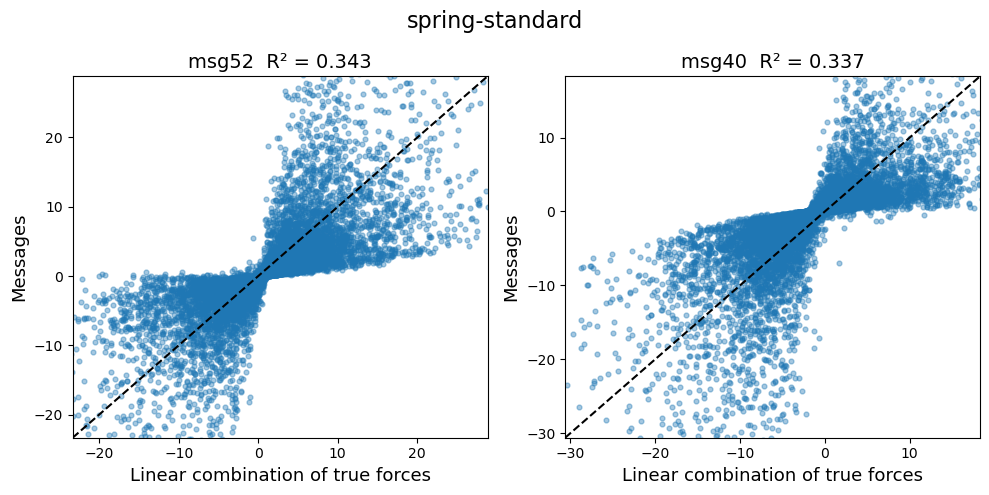

In [90]:

from message_processing import measure_latent, fit_multioutput_force
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Measure latent variables
latent_df_standard = measure_latent(model_standard, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_standard['fx_true'] = -(latent_df_standard['r'] - 1) * (latent_df_standard['dx'] / (latent_df_standard['r'] + 1e-6))
latent_df_standard['fy_true'] = -(latent_df_standard['r'] - 1) * (latent_df_standard['dy'] / (latent_df_standard['r'] + 1e-6))

# Fit multi-output linear regression to find top channels
lr, top_channels= fit_multioutput_force(latent_df_standard, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_standard[['fx_true','fy_true']].values

# True messages
Messages = latent_df_standard[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("spring-standard", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()



In [91]:
import pysr
sr_standard= pysr.PySRRegressor(
  niterations=100,
  binary_operators=["+", "-", "*", "/"],
  run_id="spring-standard",
  random_state=seed,
  parallelism="serial",
)
df_sub_standard = latent_df_standard[['dx','dy','r', top_channels[0]]].sample(5000, random_state=seed)
X = df_sub_standard[['dx','dy','r']].values
Y = df_sub_standard[top_channels[0]].values
sr_standard.fit(X, Y)
print(sr_standard)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 6.090e+04
Progress: 319 / 3100 total iterations (10.290%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.862e+02  1.594e+01  y = x₂
3           1.477e+02  1.159e-01  y = x₀ * -5.5063
5           1.393e+02  2.919e-02  y = (x₂ * x₀) / -0.39718
7           1.366e+02  1.002e-02  y = x₂ - (x₂ * (x₀ / 0.39676))
9           1.354e+02  4.370e-03  y = (x₂ - ((x₂ * x₀) / 0.39684)) - x₁
11          1.348e+02  2.025e-03  y = ((x₂ * ((x₀ * -2.5184) - -1.8523)) - x₁) + -1.6325
13          1.306e+02  1.593e-02  y = (1.5433 + (-1.4842 / x₂)) * (((x₀ / -0.13654) + x₂) - ...
                                      x₁)
17          1.304e+02  3.456e-04  y = (((x₂ + (x₀ - x₂)) / -0.16968) + (x₂ - x₁)) * ((-1.856...
                                      3 / x₂) + 1.93

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 5.910e+04
Progress: 1543 / 3100 total iterations (49.774%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.862e+02  1.594e+01  y = x₂
3           1.477e+02  1.159e-01  y = x₀ * -5.5063
5           1.393e+02  2.919e-02  y = x₀ * (x₂ * -2.519)
7           1.351e+02  1.528e-02  y = x₀ * ((11.092 / x₂) + -11.444)
9           1.317e+02  1.300e-02  y = x₀ * (((11.096 / x₂) + -11.442) + x₀)
11          1.305e+02  4.592e-03  y = (x₀ * (((11.096 / x₂) + -11.442) + x₀)) - x₁
13          1.304e+02  1.589e-04  y = ((-1.8464 / x₂) + 1.9212) * (x₂ + ((x₀ / -0.16892) - x...
                                      ₁))
15          1.298e+02  2.243e-03  y = ((x₀ / -0.12011) + ((x₀ * x₀) - x₁)) * ((-1.3256 / x₂)...
                                       + 1.3699)
17

### Bottleneck model

In [19]:

msg_dim_bottleneck=2

model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_bottleneck = torch.optim.Adam(model_bottleneck.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_bottleneck = OneCycleLR(opt_bottleneck, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)


In [20]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-spring-bottleneck", reinit=True)
for epoch in range(total_epochs):
    model_bottleneck.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_bottleneck.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_bottleneck.loss(batch)
        loss.backward()
        opt_bottleneck.step()
        sched_bottleneck.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.1889


Epoch 1/30, Loss: 9.446767
Epoch 2/30, Loss: 4.033806
Epoch 3/30, Loss: 2.901170
Epoch 4/30, Loss: 2.308250
Epoch 5/30, Loss: 1.842778
Epoch 6/30, Loss: 1.490528
Epoch 7/30, Loss: 1.299895
Epoch 8/30, Loss: 1.177489
Epoch 9/30, Loss: 1.080869
Epoch 10/30, Loss: 0.983926
Epoch 11/30, Loss: 0.905652
Epoch 12/30, Loss: 0.842451
Epoch 13/30, Loss: 0.787168
Epoch 14/30, Loss: 0.730781
Epoch 15/30, Loss: 0.673657
Epoch 16/30, Loss: 0.617952
Epoch 17/30, Loss: 0.570403
Epoch 18/30, Loss: 0.516921
Epoch 19/30, Loss: 0.468661
Epoch 20/30, Loss: 0.423091
Epoch 21/30, Loss: 0.380656
Epoch 22/30, Loss: 0.340213
Epoch 23/30, Loss: 0.300665
Epoch 24/30, Loss: 0.270237
Epoch 25/30, Loss: 0.239690
Epoch 26/30, Loss: 0.215496
Epoch 27/30, Loss: 0.196352
Epoch 28/30, Loss: 0.181904
Epoch 29/30, Loss: 0.172427
Epoch 30/30, Loss: 0.167688


In [21]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "spring_bottleneck.pth")

torch.save(model_bottleneck.state_dict(), save_path)

In [22]:
model_bottleneck.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_bottleneck(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.021366


Selected channels: ['msg0', 'msg1']


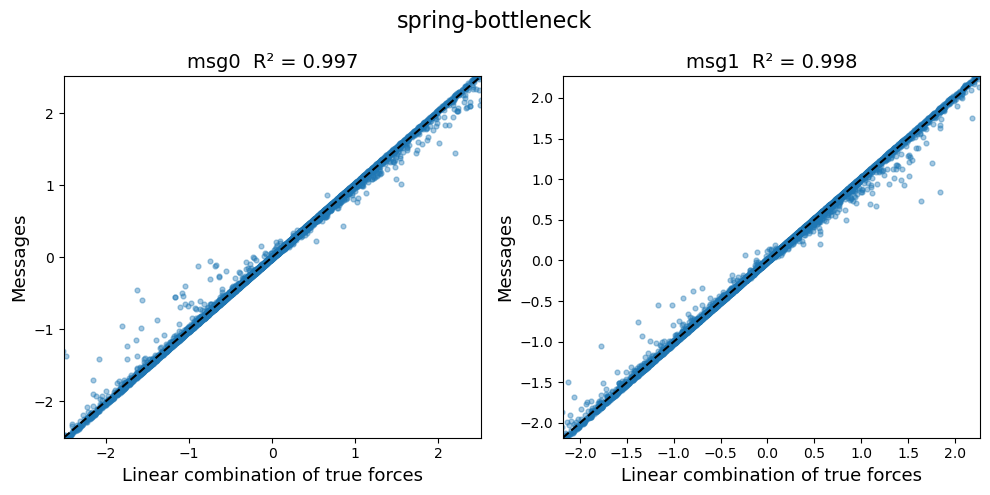

In [92]:
from message_processing import measure_latent, fit_multioutput_force
from sklearn.metrics import r2_score

# Measure latent variables
latent_df_bottleneck = measure_latent(model_bottleneck, testloader, device=device, dim=dim, msg_dim=msg_dim_bottleneck)

# compute true force components and add them to latent_df
latent_df_bottleneck['fx_true'] = -(latent_df_bottleneck['r'] - 1) * (latent_df_bottleneck['dx'] / (latent_df_bottleneck['r']+ 1e-6))
latent_df_bottleneck['fy_true'] = -(latent_df_bottleneck['r'] - 1) * (latent_df_bottleneck['dy'] / (latent_df_bottleneck['r']+ 1e-6))

# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_bottleneck, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_bottleneck[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_bottleneck[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("spring-bottleneck", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()


In [93]:
import pysr
sr_bottleneck = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    run_id="spring-bottleneck",
    random_state=seed,
    parallelism="serial"
)
df_sub_bottleneck = latent_df_bottleneck[['dx', 'dy', 'r', top_channels[0]]].sample(5000, random_state=seed)
X = df_sub_bottleneck[['dx', 'dy', 'r']].values
Y = df_sub_bottleneck[top_channels[0]].values
sr_bottleneck.fit(X, Y)
print(sr_bottleneck)



/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 6.590e+04
Progress: 360 / 3100 total iterations (11.613%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.157e-01  1.594e+01  y = 0.030526
3           2.255e-01  5.774e-01  y = x₁ * -0.59591
5           9.506e-02  4.320e-01  y = (x₁ / x₂) - x₁
7           6.179e-02  2.153e-01  y = x₁ * ((1.2641 / x₂) - 1.2804)
9           6.179e-02  3.392e-05  y = (x₁ * ((1.264 / x₂) + -1.2803)) - -0.0020508
11          1.157e-02  8.377e-01  y = ((1.2804 / x₂) - 1.2804) * (x₁ + (x₀ * 0.41715))
13          3.176e-03  6.463e-01  y = ((0.28146 * x₀) + (x₁ - 0.0032026)) * ((1.2804 / x₂) -...
                                       1.2804)
21          2.792e-03  1.611e-02  y = (((x₀ / 1.2417) + ((x₁ - (x₀ * 0.20631)) + (x₁ - 0.002...
                                  

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.157e-01  1.594e+01  y = 0.030526
3           2.255e-01  5.774e-01  y = x₁ * -0.59591
5           9.506e-02  4.320e-01  y = (x₁ / x₂) - x₁
7           6.179e-02  2.153e-01  y = x₁ * ((1.2641 / x₂) - 1.2804)
9           5.043e-02  1.016e-01  y = ((-0.16593 * x₀) - x₁) + (x₁ / x₂)
11          2.798e-03  1.446e+00  y = ((1.2641 / x₂) - 1.2789) * (x₁ + (x₀ * 0.29983))
13          2.783e-03  2.716e-03  y = (((1.264 / x₂) - 1.2787) * (x₁ + (x₀ * 0.29992))) + 0....
                                      0038957
15          2.760e-03  4.082e-03  y = (x₁ + (x₀ * 0.29994)) * ((1.289 / x₂) + ((x₂ * 0.01010...
                                      3) - 1.3144))
17          2.746e-03  2.599e-03  y = ((x₁ + (x₀ * 0.30003)) * ((1.2886 / x₂) + ((0.0099934 ...
                                      * x₂) - 1.3138))) - -0.0037857
19          2.739e-03 

### L1 regularization model

In [27]:
model_l1 = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0.02).to(device)

opt_l1 = torch.optim.Adam(model_l1.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_l1 = OneCycleLR(opt_l1, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [28]:
wandb.init(project="DIS-final-pro", name="Train-spring-l1", reinit=True)
for epoch in range(total_epochs):
    model_l1.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_l1.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_l1.loss(batch)
        loss.backward()
        opt_l1.step()
        sched_l1.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.16769


Epoch 1/30, Loss: 11.213178
Epoch 2/30, Loss: 5.113282
Epoch 3/30, Loss: 3.660104
Epoch 4/30, Loss: 2.558155
Epoch 5/30, Loss: 1.965274
Epoch 6/30, Loss: 1.795289
Epoch 7/30, Loss: 1.735601
Epoch 8/30, Loss: 1.680561
Epoch 9/30, Loss: 1.604379
Epoch 10/30, Loss: 1.512033
Epoch 11/30, Loss: 1.415056
Epoch 12/30, Loss: 1.313945
Epoch 13/30, Loss: 1.237824
Epoch 14/30, Loss: 1.156091
Epoch 15/30, Loss: 1.082742
Epoch 16/30, Loss: 1.011873
Epoch 17/30, Loss: 0.938065
Epoch 18/30, Loss: 0.867220
Epoch 19/30, Loss: 0.794627
Epoch 20/30, Loss: 0.726660
Epoch 21/30, Loss: 0.657215
Epoch 22/30, Loss: 0.587778
Epoch 23/30, Loss: 0.533283
Epoch 24/30, Loss: 0.475009
Epoch 25/30, Loss: 0.427348
Epoch 26/30, Loss: 0.387923
Epoch 27/30, Loss: 0.354437
Epoch 28/30, Loss: 0.329426
Epoch 29/30, Loss: 0.312861
Epoch 30/30, Loss: 0.303998


In [29]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "spring_l1.pth")

torch.save(model_l1.state_dict(), save_path)

In [30]:
model_l1.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_l1(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.027029


Selected channels: ['msg47', 'msg58']


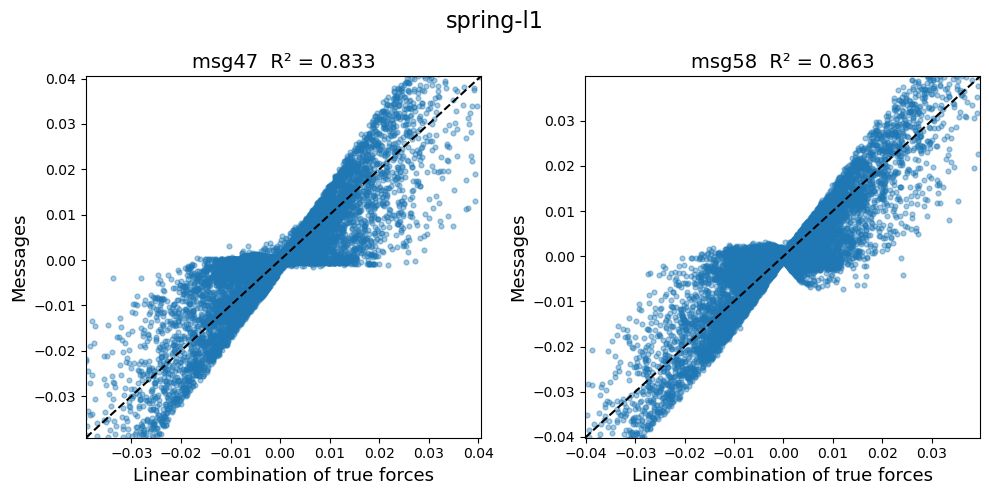

In [94]:
# Measure latent variables
latent_df_l1 = measure_latent(model_l1, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_l1['fx_true'] = -(latent_df_l1['r'] - 1) * (latent_df_l1['dx'] / (latent_df_l1['r']+ 1e-6))
latent_df_l1['fy_true'] = -(latent_df_l1['r'] - 1) * (latent_df_l1['dy'] / (latent_df_l1['r']+ 1e-6))

# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_l1, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_l1[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_l1[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("spring-l1", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()



In [97]:
import pysr
sr_l1 = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    run_id="spring-l1",
    random_state=seed,
    parallelism="serial"
)
df_sub_l1 = latent_df_l1[['dx', 'dy', 'r', top_channels[1]]].sample(5000, random_state=seed)
X = df_sub_l1[['dx', 'dy', 'r']].values
Y = df_sub_l1[top_channels[1]].values
sr_l1.fit(X, Y)
print(sr_l1)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 6.100e+04
Progress: 355 / 3100 total iterations (11.452%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.832e-04  1.594e+01  y = -0.00021234
3           7.044e-05  4.779e-01  y = x₀ * -0.0091076
5           4.467e-05  2.278e-01  y = x₀ * (x₂ * -0.0042084)
7           2.944e-05  2.084e-01  y = (x₀ - (x₀ / x₂)) * -0.019714
9           2.943e-05  2.488e-04  y = x₀ * (((1.0104 - x₂) * 0.019837) / x₂)
11          2.939e-05  6.526e-04  y = ((x₀ * ((1.0103 - x₂) * 0.019835)) + -0.00010403) / x₂
13          2.814e-05  2.179e-02  y = ((x₀ * (x₀ * 0.01494)) / (0.42619 / x₀)) / (x₂ * -6.24...
                                      67)
15          2.403e-05  7.891e-02  y = ((x₀ * x₀) - 0.52484) * ((-0.053801 / (-2.3348 / x₀)) ...
                           

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 5.500e+04
Progress: 2928 / 3100 total iterations (94.452%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.832e-04  1.594e+01  y = -0.00021234
3           7.044e-05  4.779e-01  y = x₀ * -0.0091076
5           4.467e-05  2.278e-01  y = x₀ * (x₂ * -0.0042084)
7           2.944e-05  2.084e-01  y = (x₀ - (x₀ / x₂)) * -0.019714
9           2.943e-05  2.488e-04  y = x₀ * (((1.0104 - x₂) * 0.019837) / x₂)
11          2.939e-05  6.526e-04  y = ((((1.0102 - x₂) * x₀) * 0.019834) + -0.00010404) / x₂
13          1.569e-05  3.138e-01  y = (x₀ * 0.027541) * ((0.97756 - x₂) / ((x₁ * x₁) + x₂))
15          1.336e-05  8.025e-02  y = (x₀ / x₂) * ((x₁ * (x₁ * 0.0056754)) + (0.023507 - (x₂...
                                       * 0.024839)))
17          6.725e-

### KL divergence model

In [34]:
from models import VariationNbody

In [35]:
model_kl = VariationNbody(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), beta=1.0).to(device)

opt_kl = torch.optim.Adam(model_kl.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_kl = OneCycleLR(opt_kl, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [36]:
import wandb
wandb.init(project="DIS-final-pro-kl", name="Train-spring", reinit=True)
for epoch in range(total_epochs):
    model_kl.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_kl.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_kl.loss(batch)
        loss.backward()
        opt_kl.step()
        sched_kl.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.304


Epoch 1/30, Loss: 2.939708
Epoch 2/30, Loss: 2.665762
Epoch 3/30, Loss: 2.526321
Epoch 4/30, Loss: 2.303100
Epoch 5/30, Loss: 2.264608
Epoch 6/30, Loss: 2.240088
Epoch 7/30, Loss: 2.224840
Epoch 8/30, Loss: 2.214550
Epoch 9/30, Loss: 2.204557
Epoch 10/30, Loss: 2.193605
Epoch 11/30, Loss: 2.182630
Epoch 12/30, Loss: 2.174667
Epoch 13/30, Loss: 2.168134
Epoch 14/30, Loss: 2.162032
Epoch 15/30, Loss: 2.154291
Epoch 16/30, Loss: 2.146660
Epoch 17/30, Loss: 2.141076
Epoch 18/30, Loss: 2.134168
Epoch 19/30, Loss: 2.127564
Epoch 20/30, Loss: 2.122788
Epoch 21/30, Loss: 2.115920
Epoch 22/30, Loss: 2.110043
Epoch 23/30, Loss: 2.104808
Epoch 24/30, Loss: 2.100374
Epoch 25/30, Loss: 2.096225
Epoch 26/30, Loss: 2.092360
Epoch 27/30, Loss: 2.089344
Epoch 28/30, Loss: 2.086183
Epoch 29/30, Loss: 2.085990
Epoch 30/30, Loss: 2.084926


In [37]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "spring_kl.pth")

torch.save(model_kl.state_dict(), save_path)

In [38]:
model_kl.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_kl(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 1.444902


Top μ channels: ['mu72', 'mu61']
Multi-output μ‐linear fit R² = 0.4763


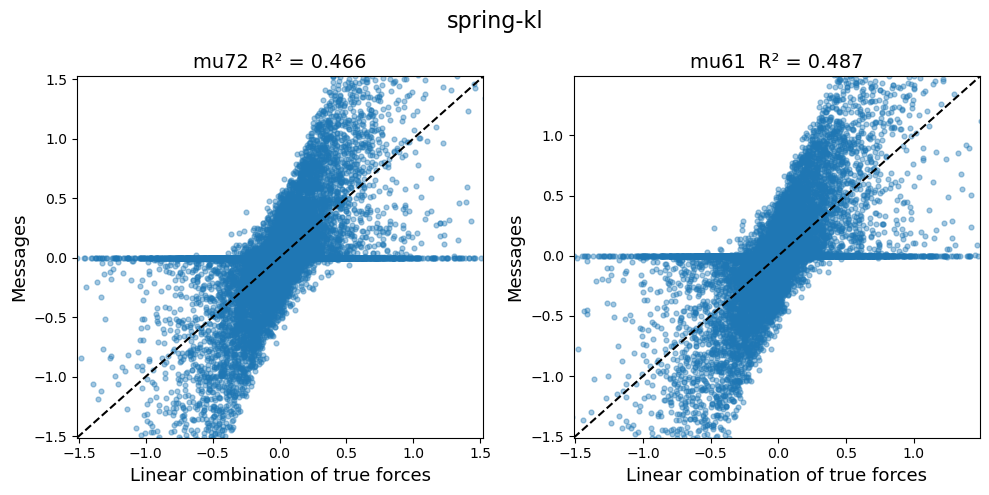

In [98]:
from message_processing import measure_variational_latent
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score   

df = measure_variational_latent(
    model_kl, testloader, device=device,
    dim=dim, msg_dim=msg_dim
)

# Select dim dimensions with largest variance
mu_cols = [c for c in df.columns if c.startswith("mu")]
top_mu  = df[mu_cols].std().nlargest(dim).index.tolist()
print("Top μ channels:", top_mu)

# compute true force components
df['fx_true'] = -(df['r'] - 1) * (df['dx'] / df['r'])
df['fy_true'] = -(df['r'] - 1) * (df['dy'] / df['r'])
Xs = df[['fx_true','fy_true']].values       # (N,2)
Ysm   = df[top_mu].values                     # (N,dim)

# # standardize X and Y_mu
# scaler_X  = StandardScaler().fit(X_raw)
# scaler_Ymu = StandardScaler().fit(Y_mu)
# Xs  = scaler_X.transform(X_raw)
# Ysm = scaler_Ymu.transform(Y_mu)

# fit 
lr_mu = LinearRegression().fit(Xs, Ysm)
r2_mu = lr_mu.score(Xs, Ysm)
print(f"Multi-output μ‐linear fit R² = {r2_mu:.4f}")
# Predicted message value using the linear regression model from the force
Predicted_messages = lr_mu.predict(Xs)

fig, axes = plt.subplots(1, dim, figsize=(10, 5))
fig.suptitle("spring-kl", fontsize=16)

for idx, ch in enumerate(top_mu):
    y_true_ch = Ysm[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()


In [99]:

import pysr
sr_kl = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    run_id="spring-kl",
    random_state=seed,
    parallelism="serial"
)
df_sub_kl = df[['dx', 'dy', 'r', top_mu[0]]].sample(5000, random_state=seed)
X = df_sub_kl[['dx', 'dy', 'r']].values
Y = df_sub_kl[top_mu[0]].values
sr_kl.fit(X, Y)
print(sr_kl)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 6.130e+04
Progress: 330 / 3100 total iterations (10.645%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.174e-01  1.594e+01  y = -0.015381
3           2.243e-01  1.735e-01  y = x₁ * 0.25975
5           2.147e-01  2.202e-02  y = (x₁ + x₀) * 0.1933
7           1.940e-01  5.048e-02  y = ((x₂ * x₁) + x₀) * 0.11745
9           1.918e-01  5.699e-03  y = x₂ * (((x₀ * -0.47481) - x₁) * -0.11607)
11          1.728e-01  5.238e-02  y = (x₀ + (x₁ + x₁)) * (0.25974 - (0.24284 / x₂))
13          1.727e-01  2.069e-04  y = (((x₀ * 0.2453) - (x₁ / -1.8968)) * (x₂ + -0.92652)) /...
                                       x₂
15          1.695e-01  9.344e-03  y = (1.8703 - (1.7414 / x₂)) * (((x₁ + x₀) + x₁) / (x₂ + 4...
                                      .7516))

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 5.610e+04
Progress: 2263 / 3100 total iterations (73.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.174e-01  1.594e+01  y = -0.015381
3           2.243e-01  1.735e-01  y = x₁ * 0.25975
5           2.147e-01  2.202e-02  y = (x₁ + x₀) * 0.1933
7           1.940e-01  5.048e-02  y = ((x₂ * x₁) + x₀) * 0.11745
9           1.892e-01  1.264e-02  y = (x₀ + x₁) * (0.38384 - (0.35524 / x₂))
11          1.728e-01  4.543e-02  y = (x₀ + (x₁ + x₁)) * (0.25974 - (0.24284 / x₂))
13          1.719e-01  2.645e-03  y = (0.25253 - (0.22378 / (x₂ - 0.03676))) * (x₁ + (x₀ + x...
                                      ₁))
15          1.694e-01  7.104e-03  y = (1.6219 - (1.5023 / x₂)) * (((x₁ + x₀) + x₁) / (x₂ + 3...
                                      .847))
1